# Generate class weights pickle array

### Generate class weights array based on classes histogram

In [1]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Pytorch: 1.7.1
Fastai: 2.2.7


In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from torchvision.utils import save_image
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import PIL 
import os

C:\Users\bruno\miniconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load dataset


In [3]:
#pathToDataSet = '/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/'
pathToDataSet = "../dataset_v1/sprint4/"
path_anno = pathToDataSet + 'gt/'
path_img = pathToDataSet + 'done/'
get_y_fn = lambda x : path_anno + f'{x.stem}_GT.png'

fnames = get_image_files(path_img)
print(len(fnames))

231


In [4]:
# get training and testing files from Multi Label Stratified Split (OPTIONAL)

"""
with open('../var/trainFilenames.pkl', 'rb') as f:
  trainFiles = pickle.load(f) #trainFiles is an array with image names that should be in the training phase
with open('../var/testFilenames.pkl', 'rb') as f:
  testFiles = pickle.load(f)

train_fnames = []
test_fnames = []
for i in range(0, len(fnames)):
    if fnames[i].name in trainFiles:
        train_fnames.append(fnames[i])
    elif fnames[i].name in testFiles:
        test_fnames.append(fnames[i])

print(len(train_fnames), len(test_fnames))

# continue the algorithm only for the these images
fnames = train_fnames + test_fnames
print(len(fnames))
"""

362 107
469


## Generate DataSet Histogram

In [4]:
totalArray = []

for i in range(0,len(fnames)):
    img = Image.open(get_y_fn(fnames[i]))
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

print('Array Generated')


Array Generated


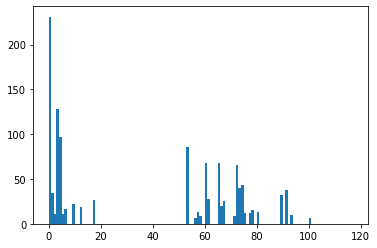

In [5]:
codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome

hist = plt.hist(totalArray, bins=len(codes), range=(0,len(codes)))
dicionario = {}


for code, contagem in zip(codes, hist[0]):
    dicionario[code] = int(contagem)

dicionario = {k: v for k, v in sorted(dicionario.items(), key=lambda item: item[1], reverse=True)} #sort



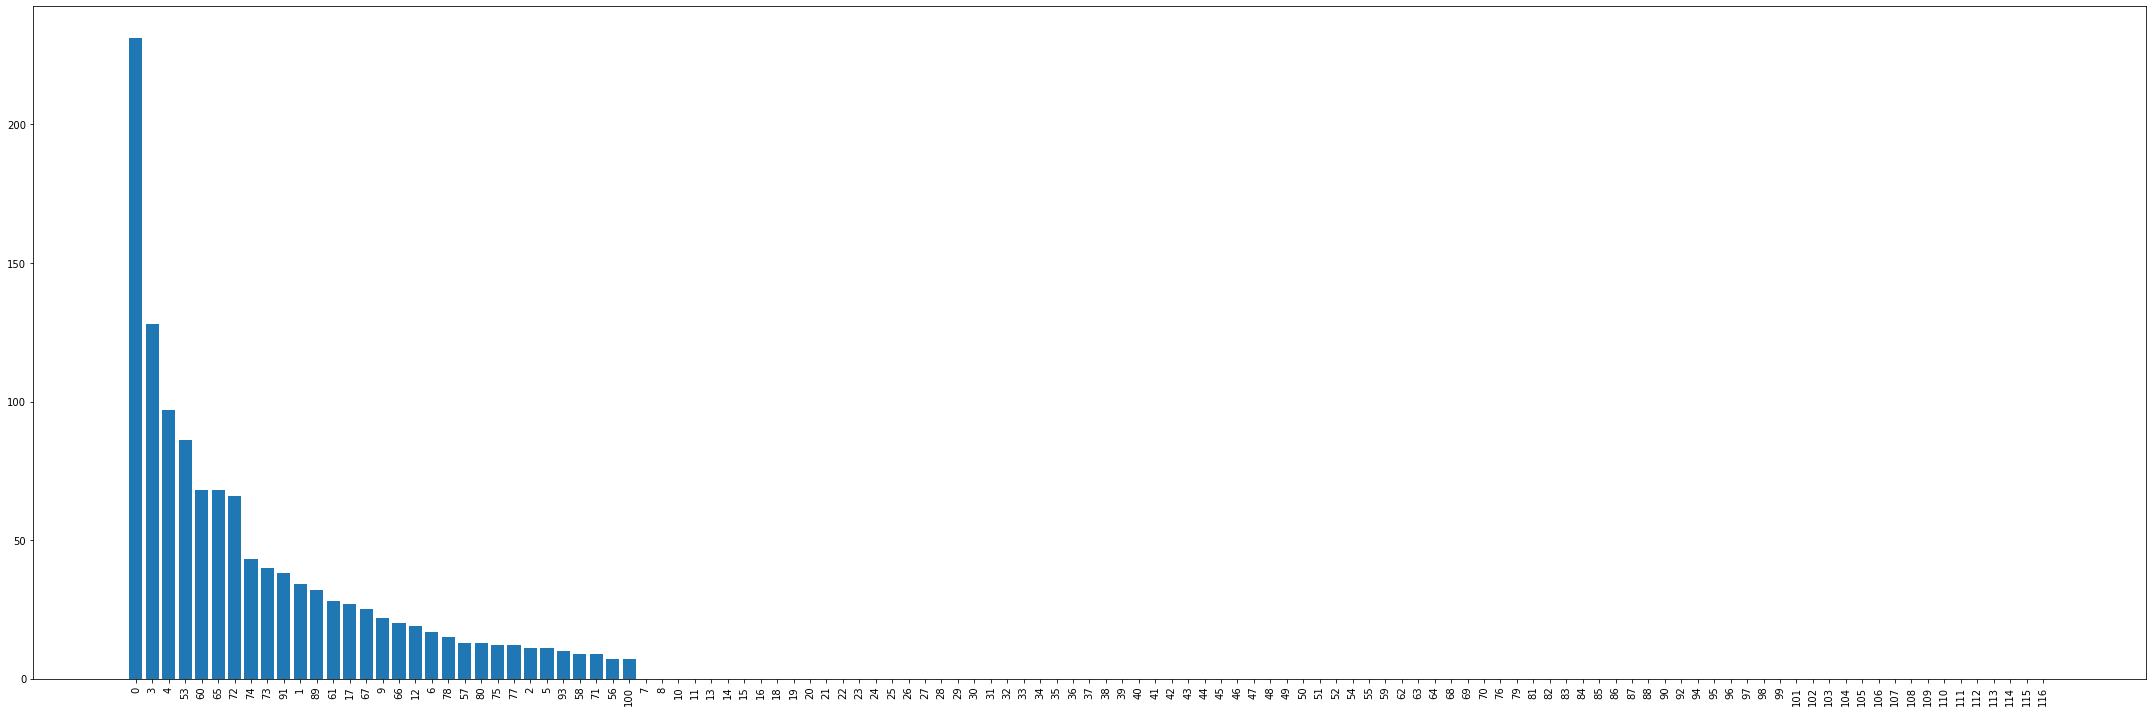

In [6]:
plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionario.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
#The idx 1 is related to the class that appears the most, except for the backGround class 0.

print('Class that most appears >>> ', list(dicionario.items())[1][0])
print('Appears >>> ', list(dicionario.items())[1][1], ' times')

dataBaseImageNumberThreshold =  list(dicionario.items())[1][1]

Class that most appears >>>  3
Appears >>>  128  times


## Class Weights based on dictionary

In [8]:
# calculate class weights from sklearn. I think the results are wrong because they consider Single Label Classification Problems

#from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(totalArray), y=totalArray)
#class_weights

In [9]:
# calculate class weights

classWeights = {}
totalValuesSum = sum(dicionario.values())
for key, value in dicionario.items():
    classWeights[key] = (1 - (value/totalValuesSum))


In [10]:
# normalize values between 1 and 100

maxValue = max(classWeights.values())
minValue = min(classWeights.values())
start = 1
end = 100
width = end - start

for key, value in classWeights.items():
    classWeights[key] = (value - minValue)/(maxValue - minValue) * width + start


#classWeights['0'] = 0.1
print(classWeights)

{'0': 1.0, '3': 45.14285714285717, '4': 58.42857142857146, '53': 63.14285714285714, '60': 70.85714285714285, '65': 70.85714285714285, '72': 71.7142857142857, '74': 81.57142857142857, '73': 82.85714285714288, '91': 83.71428571428574, '1': 85.42857142857144, '89': 86.2857142857143, '61': 88.00000000000003, '17': 88.42857142857142, '67': 89.28571428571428, '9': 90.57142857142858, '66': 91.42857142857144, '12': 91.85714285714283, '6': 92.7142857142857, '78': 93.57142857142854, '57': 94.4285714285714, '80': 94.4285714285714, '75': 94.85714285714286, '77': 94.85714285714286, '2': 95.28571428571426, '5': 95.28571428571426, '93': 95.71428571428572, '58': 96.14285714285712, '71': 96.14285714285712, '56': 96.99999999999999, '100': 96.99999999999999, '7': 100.0, '8': 100.0, '10': 100.0, '11': 100.0, '13': 100.0, '14': 100.0, '15': 100.0, '16': 100.0, '18': 100.0, '19': 100.0, '20': 100.0, '21': 100.0, '22': 100.0, '23': 100.0, '24': 100.0, '25': 100.0, '26': 100.0, '27': 100.0, '28': 100.0, '29':

In [11]:
# create array from class weights dict

classWeights = {k: v for k, v in sorted(classWeights.items(), key=lambda item: int(item[0]), reverse=False)} #sort
classWeightsArray = list(classWeights.values())

print(classWeightsArray)

[1.0, 85.42857142857144, 95.28571428571426, 45.14285714285717, 58.42857142857146, 95.28571428571426, 92.7142857142857, 100.0, 100.0, 90.57142857142858, 100.0, 100.0, 91.85714285714283, 100.0, 100.0, 100.0, 100.0, 88.42857142857142, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 63.14285714285714, 100.0, 100.0, 96.99999999999999, 94.4285714285714, 96.14285714285712, 100.0, 70.85714285714285, 88.00000000000003, 100.0, 100.0, 100.0, 70.85714285714285, 91.42857142857144, 89.28571428571428, 100.0, 100.0, 100.0, 96.14285714285712, 71.7142857142857, 82.85714285714288, 81.57142857142857, 94.85714285714286, 100.0, 94.85714285714286, 93.57142857142854, 100.0, 94.4285714285714, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 86.2857142857143, 100.0, 83.71428571428574, 100.0, 95.71428571428572, 

In [12]:
# dump arrays into pickle file

with open('./sprint4/classWeights.pkl', 'wb') as f:
  pickle.dump(classWeightsArray, f)